In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
from tqdm import tqdm
import os
import copy
import scipy.io as sio
import sys

import pyPSFstack.pupils.sources as srcs
import pyPSFstack.pupils.windows as wdws
from pyPSFstack.pupils.aberrations import UnitaryAberrations, ScalarAberrations, ApodizedUnitary
from pyPSFstack.core import PSFStack
from pyPSFstack.functions import trim_stack
import pyPSFstack.diversities.pola_diversities as pdivs
from pyPSFstack.diversities.pupil_diversities import ZDiversity
from pyPSFstack.blurring.blurring import ExactBlurring, SABlurring

from pyPSFstack_torch.psf_modules import torchPSFStack, torchTilts, torchPSFStackTilts
from pyPSFstack_torch.pupils.sources import torchDipoleInterfaceSource
from pyPSFstack_torch.pupils.windows import torchSEO
from pyPSFstack_torch.pupils.aberrations import torchUnitaryAberrations, torchScalarAberrations
from pyPSFstack_torch.diversities.pupil_diversities import torchZDiversity
from pyPSFstack_torch.diversities.pola_diversities import torchPDiversity_QWP, \
    torchPDiversity_LP, torchPDiversity_Compound
from pyPSFstack_torch.blurring.blurring import torch2DBlurring, torchSABlurring
from pyPSFstack_torch.cost_functions import loss_loglikelihood, loss_sumsquared
from pyPSFstack_torch.functions import get_pupils_param_dict, get_normNbck, colorize


from functions4man import plot_zpstack, plot_zstack, plot_xyz, plot_jones, \
    get_xyzstack, find_pupil, cpx_corr, find_exp_pupil
    
fig_folder='figures'

device = 'cuda' if torch.cuda.is_available() else 'cpu'



# matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({"figure.facecolor" : "white"})

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# Characterizing a birefringent window from an experimental PSF stack

## 1. Parameters used for the experimental acquisition

In [222]:
# Define number of points use for the computation 
N_pts = 128
# Experimental parameters
numerical_aperture = 1.49
magnification = 100 
ni = 1.33
nf = 1.518
cam_pixel_size = 6500
radius = 10
wavelength = 525
# Define positions of defocus
zi = -500; z_step = 50; zf=0
z_list = - np.arange(zi,zf+z_step,z_step)
# Define rotation angles of polarization analyzer
angle_i = -np.pi/4; angle_f = 3*np.pi/4; angle_step = np.pi/6
angle_list=np.arange(angle_i,angle_f+angle_step,angle_step)
alpha = 1.24211

We put all the parameters in a dictionary 

In [159]:
-0.1+ 1*np.pi/4

0.6853981633974483

In [223]:
params = {}
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = N_pts

params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = radius/wavelength

params['defocus'] = {}
params['defocus']['nf'] = nf
params['defocus']['delta_z'] = 0

params['seo'] = {}
params['seo']['c'] = 4.5#6.27#4.53
params['seo']['phi'] = 0.42+0*np.pi/4

params['zdiversity'] = {}
params['zdiversity']['z_list'] = z_list / wavelength
params['zdiversity']['nf'] = nf

params['pdiversity'] = {}
params['pdiversity']['gwp_angles'] = -angle_list +0*np.pi/2
params['pdiversity']['eta'] = 0.48*np.pi
params['pdiversity']['lp_angles'] = [np.pi/2,0]

params['aberrations'] = {}
params['aberrations']['jmax_list'] = [15]*4+[15]

In [224]:
np.pi/4

0.7853981633974483

Instantiate all the class elements need to define a PSF stack

In [225]:
src = srcs.DipoleInterfaceSource(**params['pupil'],**params['source'])
seo = wdws.SEO(**params['pupil'],**params['seo'])
# Then the diversities
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])
gwp = pdivs.PDiversity_GWP(params['pdiversity']['gwp_angles'], params['pdiversity']['eta'])
# wollaston = pdivs.PDiversity_LP([0, np.pi/2])
wollaston = pdivs.PDiversity_LP(params['pdiversity']['lp_angles'])
pdiv = pdivs.PDiversity_Compound([gwp, wollaston])

pol_seo = pdivs.PDiversity_Compound([pdivs.PDiversity_QWP([np.pi/4]), wollaston])


In [226]:
psfs = PSFStack([src, seo], zdiversity=zdiv, pdiversity=pdiv)
psfs.compute_psf_stack(orientation=[0,0,0], N_trim=21)

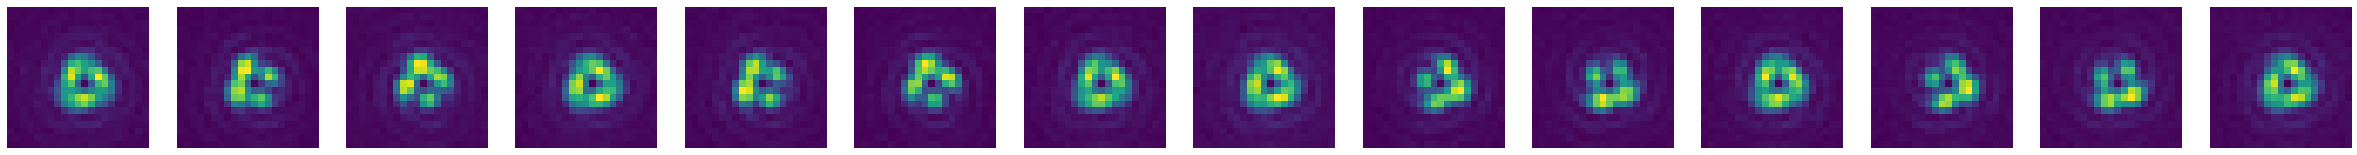

In [227]:
mod_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=40000,noise=True)
zdiv_mid_ind = -1
fig, axs = plt.subplots(1,14,figsize=(3*14,3))
for ind in range(14):
    axs[ind].imshow(mod_stack[...,zdiv_mid_ind,ind])
for ax in axs.ravel():
    ax.set_axis_off()

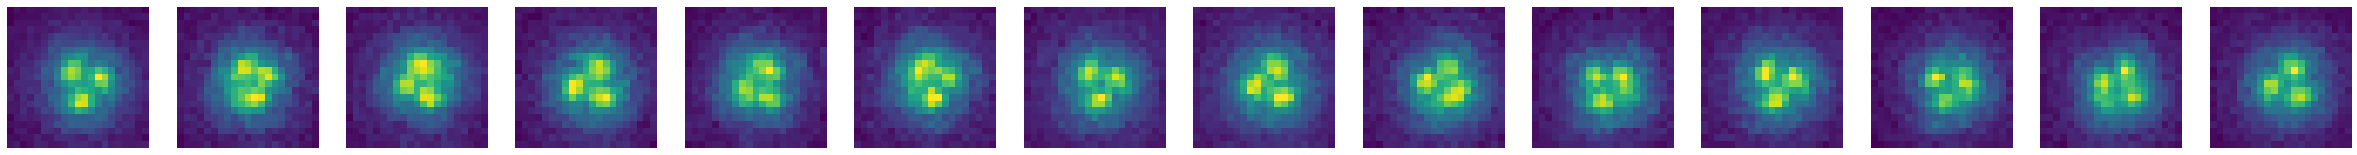

In [206]:
mod_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=40000,noise=True)
zdiv_mid_ind = 5
fig, axs = plt.subplots(1,14,figsize=(3*14,3))
for ind in range(14):
    axs[ind].imshow(mod_stack[...,zdiv_mid_ind,ind])
for ax in axs.ravel():
    ax.set_axis_off()

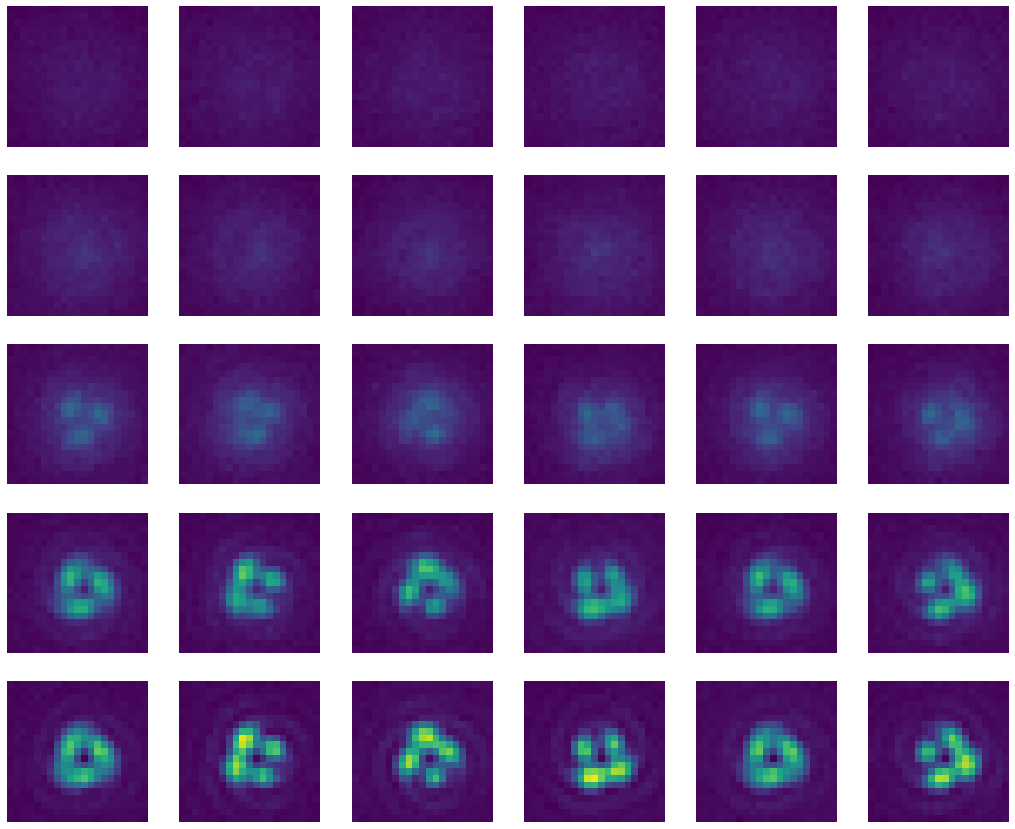

In [207]:
mod_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=40000,noise=True)
zdiv_mid_ind = 5
delz=3
plist=[0,1,2,9,10,11]
max_val = np.max(mod_stack)
fig, axs = plt.subplots(5,len(plist),figsize=(3*len(plist),3*5))
for ind,pind in enumerate(plist):
    axs[0,ind].imshow(mod_stack[...,0,pind], vmax=max_val)
    axs[1,ind].imshow(mod_stack[...,zdiv_mid_ind-delz,pind], vmax=max_val)
    axs[2,ind].imshow(mod_stack[...,zdiv_mid_ind,pind], vmax=max_val)
    axs[3,ind].imshow(mod_stack[...,zdiv_mid_ind+delz,pind], vmax=max_val)
    axs[4,ind].imshow(mod_stack[...,-1,pind], vmax=max_val)
for ax in axs.ravel():
    ax.set_axis_off()

## 2. Look at the data and determine good initial parameters

In [7]:
mat_data = sio.loadmat(os.path.join('data','Captured_Run7.mat'))

In [69]:
bead_n = 0
# exp_stack = np.flip(0.24*(mat_data['Rodrigos'][bead_n]-80), axis=0)
exp_stack = 0.24*(mat_data['Rodrigos'][bead_n]-80)
exp_stack[exp_stack<=0] 

array([], dtype=float64)

In [4]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Rodrigos', 'PSFsH', 'PSFsV', 'Zstep', 'Polstep', 'Pols', 'CoordsV', 'CoordsH', 'Nbeads', 'SBR', 'Hist val', 'label'])

In [8]:
mat_data['Rodrigos'].shape

(8, 21, 21, 11, 14)

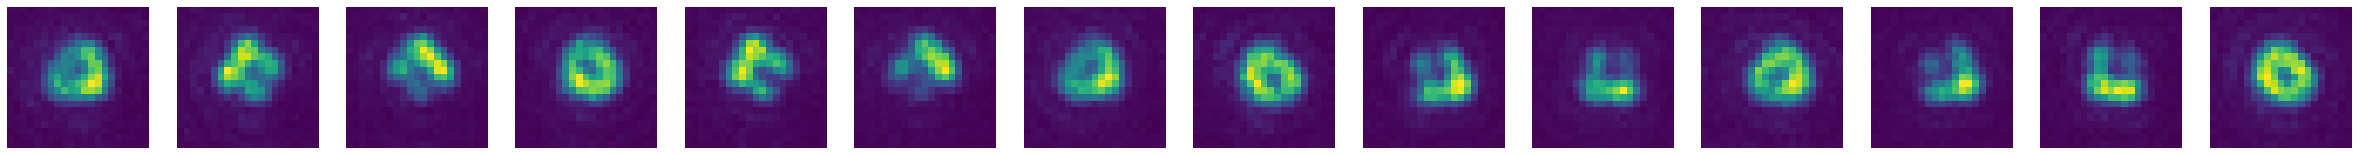

In [134]:
zdiv_mid_ind = -1
fig, axs = plt.subplots(1,14,figsize=(3*14,3))
for ind in range(14):
    axs[ind].imshow(exp_stack[...,zdiv_mid_ind,ind])
for ax in axs.ravel():
    ax.set_axis_off()

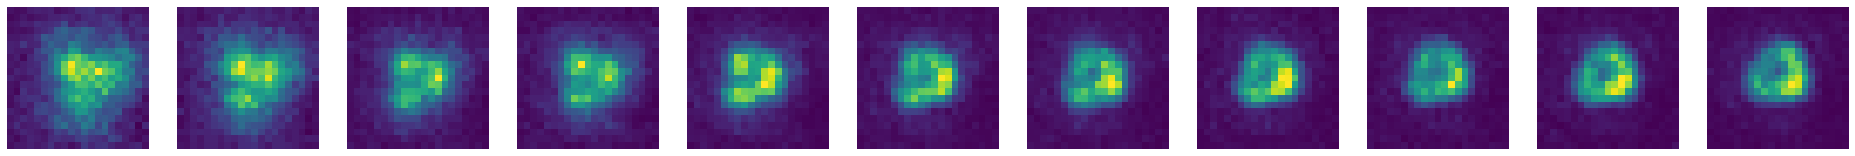

In [99]:
zdiv_mid_ind = 5
fig, axs = plt.subplots(1,11,figsize=(3*11,3))
for ind in range(11):
    axs[ind].imshow(exp_stack[...,ind,0])
for ax in axs.ravel():
    ax.set_axis_off()

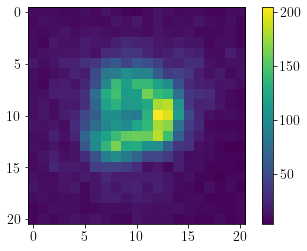

In [101]:
plt.imshow(exp_stack[...,5,0])
plt.colorbar()

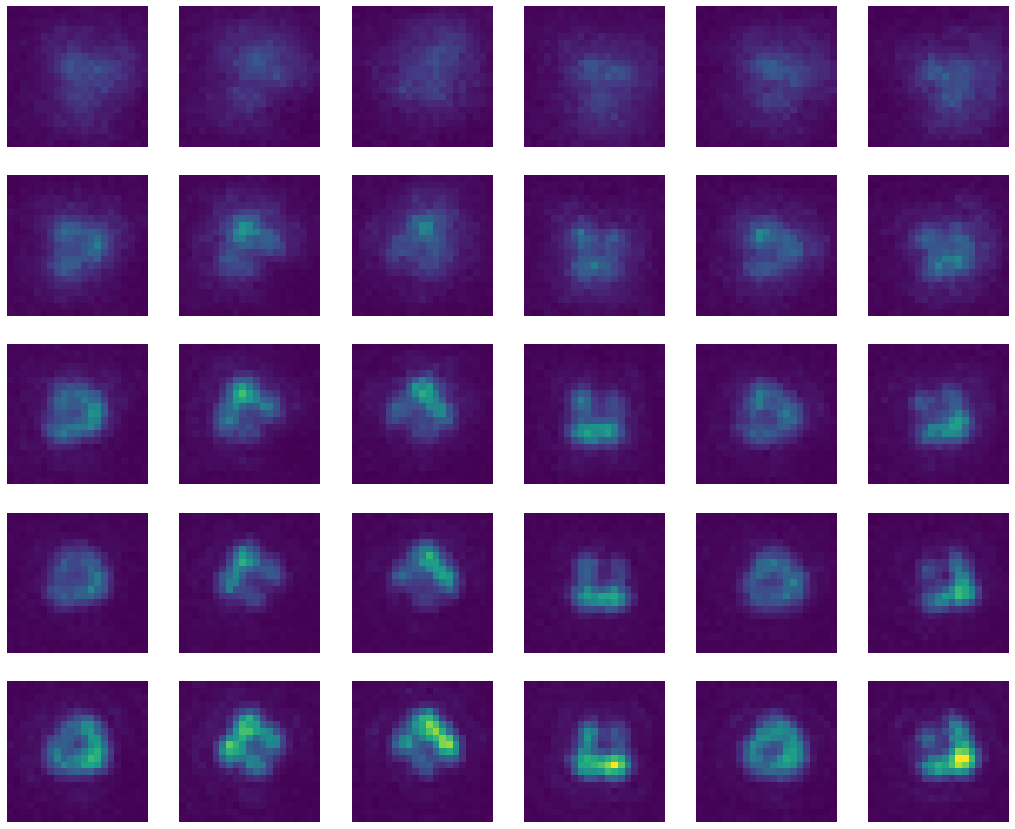

In [103]:
zdiv_mid_ind = 5
delz=3
plist=[0,1,2,9,10,11]
max_val = np.max(exp_stack)
fig, axs = plt.subplots(5,len(plist),figsize=(3*len(plist),3*5))
for ind,pind in enumerate(plist):
    axs[0,ind].imshow(exp_stack[...,0,pind], vmax=max_val)
    axs[1,ind].imshow(exp_stack[...,zdiv_mid_ind-delz,pind], vmax=max_val)
    axs[2,ind].imshow(exp_stack[...,zdiv_mid_ind,pind], vmax=max_val)
    axs[3,ind].imshow(exp_stack[...,zdiv_mid_ind+delz,pind], vmax=max_val)
    axs[4,ind].imshow(exp_stack[...,-1,pind], vmax=max_val)
for ax in axs.ravel():
    ax.set_axis_off()

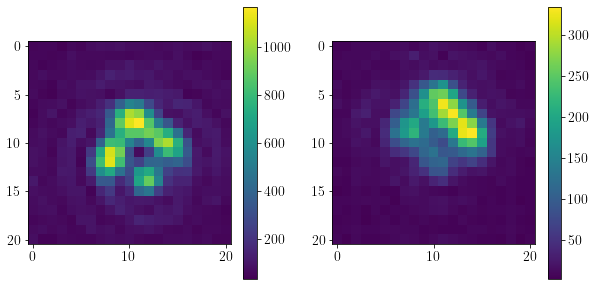

In [208]:
zin=-1; pin=2
fig, axs = plt.subplots(1,2,figsize=(2*5,5))
im0 = axs[0].imshow(mod_stack[...,zin,pin])
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(exp_stack[...,zin,pin])
fig.colorbar(im1, ax=axs[1])

## 2. Retrieve pupil

100%|██████████| 80/80 [01:07<00:00,  1.18it/s]


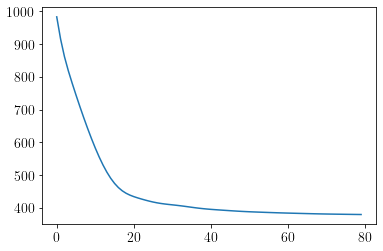

In [209]:
# torch_blurr2d = torch2DBlurring(radius=radius/wavelength,**params['pupil'],opt_radius=True)
params['aberrations'] = {}
params['aberrations']['jmax_list'] = 4*[15]+[15]+[1]
model, loss_evol = find_exp_pupil(exp_stack.copy(), params, lr=2e-2, n_epochs=80, 
    loss_fn=loss_sumsquared, abe=False, seo=True, opt_delta=False, 
    opt_def=True, opt_a=True, tilts=True, defocuses=False)
plt.plot(loss_evol)

In [210]:
ret_pupil_params = get_pupils_param_dict(model)
ret_pupil_params

{'pupil0': {},
 'pupil1': {'delta_z': array(-0.23598723, dtype=float32)},
 'pupil2': {'c': array(4.5960765, dtype=float32),
  'phi': array(0.18313566, dtype=float32),
  'center': array([ 0.04940713, -0.16051356], dtype=float32)},
 'pb_bck': {'b': array([[ 9.667633 ,  9.694844 ,  9.968492 , 10.18675  , 10.100495 ,
           9.913709 ,  9.892061 ,  9.937704 ,  9.836697 ,  9.754254 ,
           9.7755165,  9.9137745, 10.041422 , 10.099348 ],
         [ 9.678546 ,  9.813317 ,  9.879617 ,  9.926078 ,  9.787987 ,
           9.808941 ,  9.656836 ,  9.859438 , 10.005118 ,  9.75347  ,
           9.586067 ,  9.710564 ,  9.95468  ,  9.920883 ],
         [ 9.408821 ,  9.426221 ,  9.482257 ,  9.700031 ,  9.540883 ,
           9.49103  ,  9.116652 ,  9.583538 ,  9.556425 ,  9.499087 ,
           9.4617   ,  9.457215 ,  9.700013 ,  9.387219 ],
         [ 9.788825 ,  9.404565 ,  9.770359 ,  9.94533  ,  9.620838 ,
           8.980413 ,  9.184805 ,  9.967758 ,  9.436219 ,  9.873467 ,
           9.60853

In [10]:
exp_stack = 0.24*(mat_data['Rodrigos'][bead_n]-80)
exp_stack[exp_stack<=0] 

array([], dtype=float64)

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


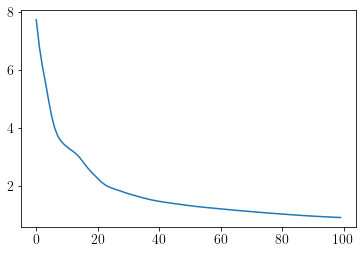

In [230]:
# torch_blurr2d = torch2DBlurring(radius=radius/wavelength,**params['pupil'],opt_radius=True)
params['aberrations'] = {}
params['aberrations']['jmax_list'] = 4*[9]+[9]+[1]
model, loss_evol = find_exp_pupil(exp_stack.copy(), params, lr=3e-2, n_epochs=100, 
    loss_fn=loss_loglikelihood, abe=True, seo=False, opt_delta=True, 
    opt_def=True, opt_a=True, tilts=True, defocuses=False)
plt.plot(loss_evol)
# plt.gca().set_yscale('log')

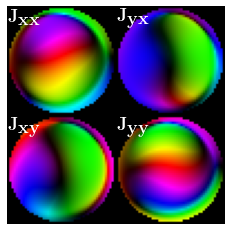

In [231]:
ret_pupil_params = get_pupils_param_dict(model)
abe = ApodizedUnitary(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())
# plt.savefig("jones_ret.pdf")

In [232]:
pup_seq = [srcs.DipoleInterfaceSource(**params['pupil'], **params['source']), 
     wdws.Defocus(**params['pupil'], **ret_pupil_params['pupil1']), 
      abe]
# blur_ret = SABlurring(radius=ret_pupil_params['blurring']['radius'],**params['pupil'])
psfs_ret = PSFStack(pup_seq , zdiversity=zdiv, pdiversity=pdiv)#, blurring=blur_ret)
psfs_ret.compute_psf_stack(orientation=[0,0,0], N_trim=21)
ret_stack = psfs_ret.psf_stack

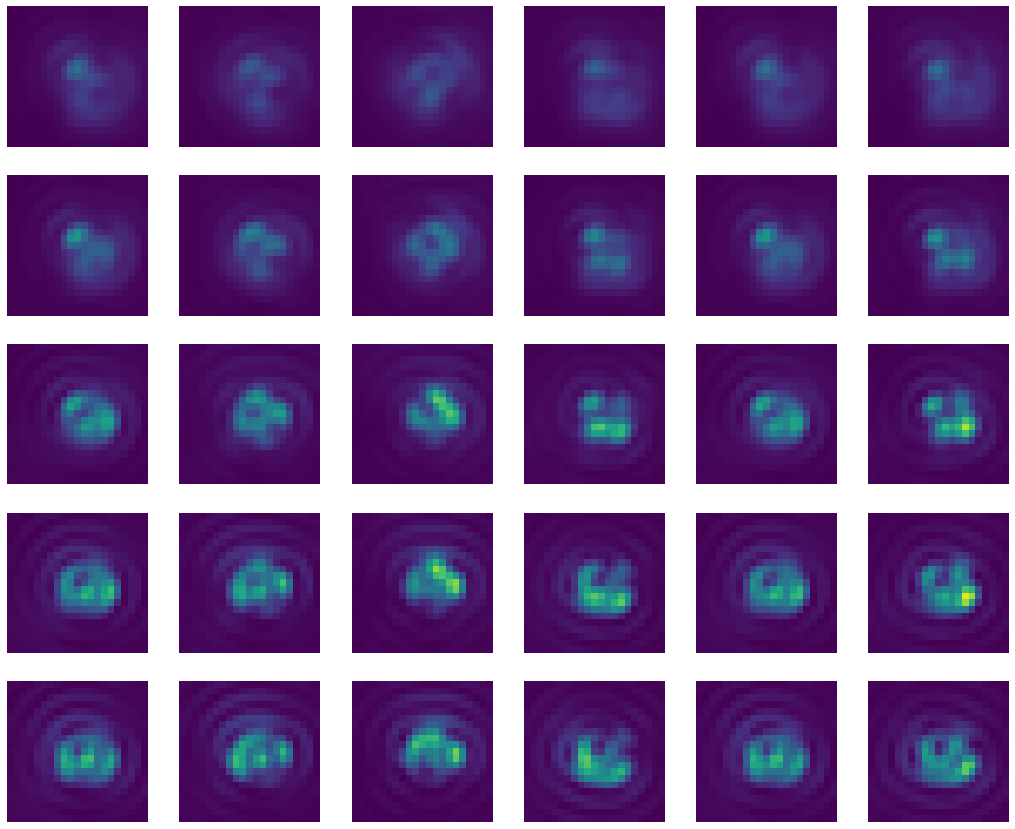

In [233]:
zdiv_mid_ind = 5
delz=3
plist=[0,1,2,9,10,11]
max_val = np.max(ret_stack)
fig, axs = plt.subplots(5,len(plist),figsize=(3*len(plist),3*5))
for ind,pind in enumerate(plist):
    axs[0,ind].imshow(ret_stack[...,0,pind], vmax=max_val)
    axs[1,ind].imshow(ret_stack[...,zdiv_mid_ind-delz,pind], vmax=max_val)
    axs[2,ind].imshow(ret_stack[...,zdiv_mid_ind,pind], vmax=max_val)
    axs[3,ind].imshow(ret_stack[...,zdiv_mid_ind+delz,pind], vmax=max_val)
    axs[4,ind].imshow(ret_stack[...,-1,pind], vmax=max_val)
for ax in axs.ravel():
    ax.set_axis_off()

off centered seo

In [13]:
ret_pupil_params = get_pupils_param_dict(model)
ret_pupil_params

{'pupil0': {},
 'pupil1': {'delta_z': array(0.1537681, dtype=float32)},
 'pupil2': {'c_A': array([1.0412536], dtype=float32),
  'c_W': array([ 0.08129772, -0.05009737,  0.00456825,  0.00901981, -0.000953  ,
         -0.01975594,  0.02129808,  0.00470143,  0.00047337, -0.01077145,
          0.00742535, -0.02124018, -0.01954256], dtype=float32),
  'c_q': [array([ 0.25118446, -0.531279  ,  0.13524455,  0.19876018, -0.3029204 ,
          -0.26437068,  0.41835305, -0.7306777 , -0.16726246,  0.18549246,
           0.183939  , -0.12760472,  0.098013  ,  0.23202968, -0.09105509],
         dtype=float32),
   array([ 6.2382793e-01,  1.7885938e-01,  5.6908894e-01, -3.2186102e-02,
           1.9391517e-01,  1.3015931e+00, -9.0276822e-02, -8.2599424e-02,
          -1.2997283e-01,  6.2034905e-01, -3.0280048e-01, -3.7778042e-02,
          -5.6247306e-01, -2.1527439e-01, -1.3968325e-04], dtype=float32),
   array([ 0.09350569,  0.14282095,  1.065878  , -0.08936907, -0.20477472,
           0.31304747,  

In [33]:
ret_pupil_params['pb_bck']['a']

array([[1.2714418 , 1.2286404 , 1.1081303 , 1.0822512 , 1.0781847 ,
        1.215072  , 0.98727894, 1.1278962 , 1.0385218 , 1.3848412 ,
        1.1640363 , 1.2458363 , 1.1181062 , 1.181872  , 1.1307118 ,
        1.1412507 , 1.1370665 , 1.1803434 ],
       [0.9060151 , 1.0645931 , 0.93842965, 0.99883217, 0.9710725 ,
        0.98303974, 0.9452723 , 0.963351  , 0.90922004, 1.0346612 ,
        0.9885556 , 1.0560834 , 1.0267093 , 1.0688944 , 0.9281119 ,
        1.0561082 , 0.96674675, 1.0211374 ],
       [0.8464655 , 0.8599262 , 0.8385515 , 0.8474539 , 0.81257415,
        0.9266371 , 0.82009125, 0.83400095, 0.7973715 , 0.93365574,
        0.8319674 , 0.90937144, 0.87561595, 0.9001419 , 0.84021103,
        0.909283  , 0.85390854, 0.87951374],
       [0.8698646 , 0.87873244, 0.9306737 , 0.9506107 , 0.9563571 ,
        1.065808  , 0.949826  , 0.9905591 , 0.99826646, 0.94141775,
        0.80979353, 1.019907  , 0.97244227, 1.0417894 , 0.9880326 ,
        1.0400479 , 1.0068791 , 1.0570682 ],
    

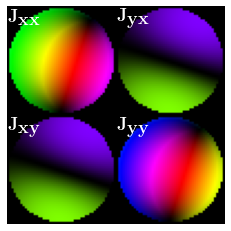

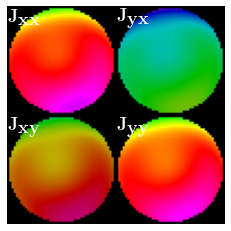

In [29]:
ret_pupil_params = get_pupils_param_dict(model)
ret_seo = wdws.SEO(**params['pupil'], 
     **ret_pupil_params['pupil1'])
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(ret_seo.get_pupil_array())
plot_jones(abe.get_pupil_array())

In [20]:
ret_pupil_params['blurring']['radius']

array(0.21542445, dtype=float32)

In [28]:
pup_seq = [srcs.DipoleInterfaceSource(**params['pupil'], **ret_pupil_params['pupil0']), 
     wdws.Defocus(**params['pupil'], **ret_pupil_params['pupil1']), 
      ret_seo, abe]
# blur_ret = SABlurring(radius=ret_pupil_params['blurring']['radius'],**params['pupil'])
psfs_ret = PSFStack(pup_seq , zdiversity=zdiv, pdiversity=pdiv)#, blurring=blur_ret)
psfs_ret.compute_psf_stack(orientation=[0,0,0], N_trim=40)
ret_stack = psfs_ret.psf_stack

TypeError: __init__() got an unexpected keyword argument 'c'

In [30]:
pup_seq = [srcs.DipoleInterfaceSource(**params['pupil'], **params['source']), 
       ret_seo, abe]
zdivs = ZDiversity(z_list=params['zdiversity']['z_list']+np.mean(model.defocuses.state_dict()['delta_zs'].detach().numpy(), axis=-1), **params['pupil'])
psfs_ret = PSFStack(pup_seq , zdiversity=zdiv, pdiversity=pdiv)
psfs_ret.compute_psf_stack(orientation=[0,0,0], N_trim=40)
ret_stack = psfs_ret.psf_stack

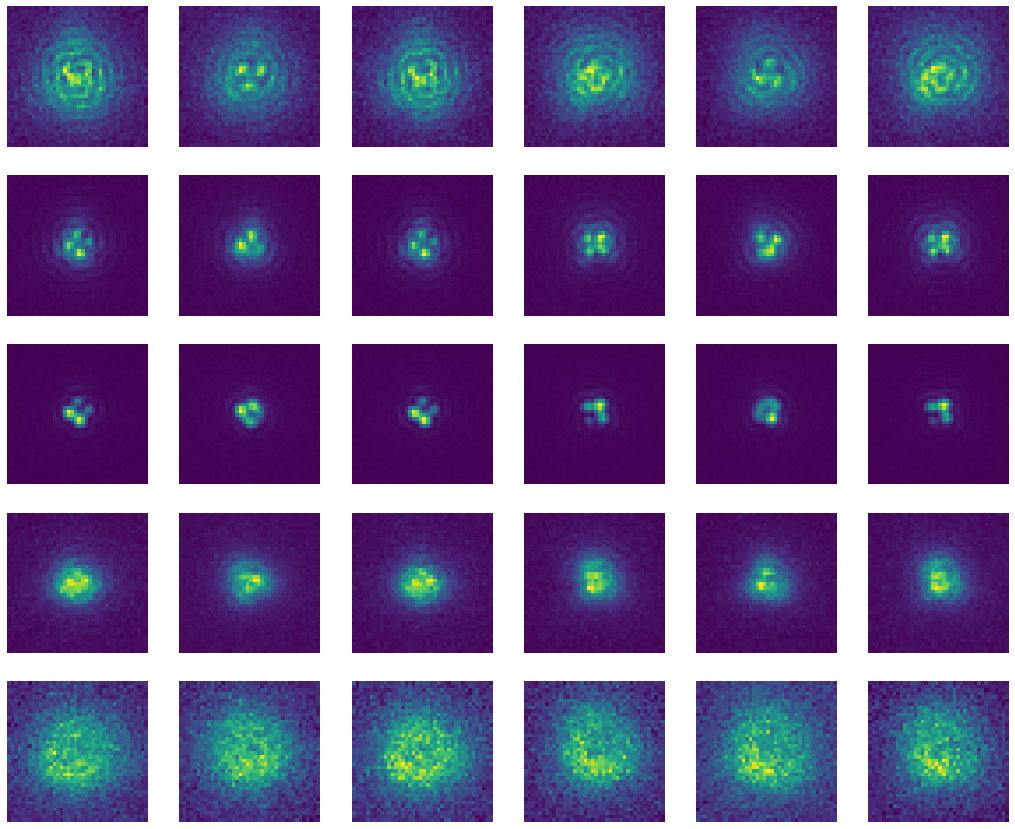

In [31]:
ret_stack = psfs_ret.model_experimental_stack(bckgd_photons=10,N_photons=40000,noise=True)
zdiv_mid_ind = 6
zdiv_mid_ind = 6
delz=3
plist=[0,1,2,9,10,11]
fig, axs = plt.subplots(5,len(plist),figsize=(3*len(plist),3*5))
for ind,pind in enumerate(plist):
    axs[0,ind].imshow(ret_stack[...,0,pind])
    axs[1,ind].imshow(ret_stack[...,zdiv_mid_ind-delz,pind])
    axs[2,ind].imshow(ret_stack[...,zdiv_mid_ind,pind])
    axs[3,ind].imshow(ret_stack[...,zdiv_mid_ind+delz,pind])
    axs[4,ind].imshow(ret_stack[...,-1,pind])
for ax in axs.ravel():
    ax.set_axis_off()

In [ ]:
zdiv_mid_ind = 7
npol=9
bead_n = 0
delz=1
npol_init=9
fig, axs = plt.subplots(5,npol,figsize=(3*npol,3*5))
for ind in range(npol):
    axs[0,ind].imshow(mod_stack[...,0,ind+npol_init])
    axs[1,ind].imshow(mod_stack[...,zdiv_mid_ind-delz,ind+npol_init])
    axs[2,ind].imshow(mod_stack[...,zdiv_mid_ind,ind+npol_init])
    axs[3,ind].imshow(mod_stack[...,zdiv_mid_ind+delz,ind+npol_init])
    axs[4,ind].imshow(mod_stack[...,-1,ind+npol_init])
for ax in axs.ravel():
    ax.set_axis_off()

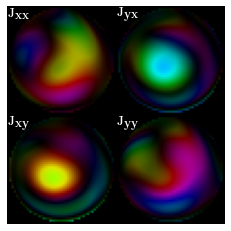

In [108]:
ret_pupil_params = get_pupils_param_dict(model)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil1'])
plot_jones(abe.get_pupil_array())

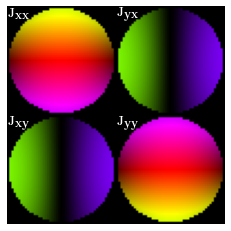

In [79]:
plot_jones(seo.get_pupil_array())